In [1]:
import numpy as np
import scipy.constants as phy_const
import matplotlib.pyplot as plt
import pickle
import math as math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
import pandas as pd
import pickle
import glob
import sys
import configparser
import string
from scipy.signal import find_peaks



listAlphabet = list(string.ascii_lowercase)

colors = ['red', 'blue', 'green', 'orange']

In [2]:
#plt.style.use('/home/petronio/style_fp.mplstyle')
plt.rcParams["font.family"] = 'serif'

In [3]:
def find_BM_freq(fft_ampl, fft_freq):
    vec = np.where(fft_freq > 4e3, fft_ampl, 0)
    # print(vec)
    return fft_freq[np.argmax(vec)], np.amax(vec)

def get_files(ResultsData):
    files       = glob.glob(ResultsData + "/*.pkl")
    files.sort(key=os.path.getmtime)
    return files

def calc_curr(Results):
    # try :
    #     time_scale, Id_interp = np.loadtxt(Results + "aacur.dat")
    #     print("Loaded current values")
    # except:
    # open all the files in the directory and sort them to do the video in order
    files       = glob.glob(Results + "/Data/*.pkl")
    filesSorted = sorted(files, key = lambda x: os.path.getmtime(x), reverse=True)
    files.sort(key=os.path.getmtime)
    Current = np.zeros(np.shape(files)[0])
    Voltage = np.zeros(np.shape(files)[0])
    time    = np.zeros(np.shape(files)[0])
    # print(np.size(Current))
    Iroll = 0
    # print(f"{np.shape(files)} files found")
    
    for i_save, file in enumerate(files):

        with open(file, 'rb') as f:
            [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)

        # Save the current
        Current[i_save] = J
        Voltage[i_save] = V
        time[i_save]    = t
    
    time_scale = np.linspace(0, time[-1], len(time)*2)
    Id_interp = np.interp(time_scale, time, Current)
    Va_interp = np.interp(time_scale, time, Voltage) 
    del(files)
    np.savetxt(Results + "cur.dat", np.vstack((time_scale, Id_interp)))
    
    return time_scale, Id_interp, Va_interp#, time, Current, Voltage

def read_input_and_set_globals(input_file):
    '''Reads the input file and sets the global variables
    TO BE COPIED AT THE BEGINNING OF THE MAIN FUNCTION, OTHERWISE THE GLOBAL VARIABLES WILL NOT BE SET'''
    global VG, M, m, R1, R2, A0, LENGTH, L0, alpha_B1, alpha_B2, mdot, Te_Cath, Rext, V0, Estar
    global NBPOINTS, SAVERATE, CFL, TIMEFINAL, TIMESCHEME, Delta_x, AlphaModel, alpha_B, Curr_ref, Thrust_ref, ISP_ref, Eta_ref

    config = configparser.ConfigParser()
    config.read(input_file)

    physicalParameters = config['Physical Parameters']

    Gas_type = physicalParameters["Gas"]
    VG       = float(physicalParameters['Gas velocity'])
    m        = phy_const.m_e
    R1       = float(physicalParameters['Inner radius'])
    R2       = float(physicalParameters['Outer radius'])
    A0       = np.pi * (R2 ** 2 - R1 ** 2)
    LENGTH   = float(physicalParameters['Length of axis'])
    L0       = float(physicalParameters['Length of thruster'])
    alpha_B1 = float(physicalParameters['Anomalous transport alpha_B1'])
    alpha_B2 = float(physicalParameters['Anomalous transport alpha_B2'])
    mdot     = float(physicalParameters['Mass flow'])
    Te_Cath  = float(physicalParameters['Temperature Cathode'])
    Rext     = float(physicalParameters['Ballast resistor'])
    V0       = float(physicalParameters['Voltage'])
    Estar    = float(physicalParameters['Crossover energy'])
    # WALLCOLLS= bool(physicalParameters['Wall collisions'])               # Wall collisions
    Circuit  = bool(config.getboolean('Physical Parameters', 'Circuit', fallback=False)) # RLC Circuit


    NumericsConfig = config['Numerical Parameters']

    NBPOINTS  = int(NumericsConfig['Number of points'])
    SAVERATE  = int(NumericsConfig['Save rate'])
    CFL       = float(NumericsConfig['CFL'])
    TIMEFINAL = float(NumericsConfig['Final time'])
    TIMESCHEME = NumericsConfig['Time integration']
    AlphaModel = NumericsConfig['Anomalous transport model']         

    Delta_x  = LENGTH/NBPOINTS
    x_center = np.linspace(0, LENGTH, NBPOINTS)
    
    Safrandata = config['Safran data']

    Curr_ref  = float(Safrandata['Mean current'])
    Thrust_ref = float(Safrandata['Thrust'])
    ISP_ref  = int(Safrandata['ISP'])
    Eta_ref = int(Safrandata['Efficiency'])

    # Ion mass
    if Gas_type == 'Xenon':
        M = 131.293 * phy_const.m_u
    elif Gas_type == 'Krypton':
        M = 83.798 * phy_const.m_u

    # Magnetic field configuration
    MagneticFieldConfig = config['Magnetic field configuration']

    if MagneticFieldConfig['Type'] == 'Default':
        # print(MagneticFieldConfig['Type'] + ' Magnetic Field')

        Bmax     = float(MagneticFieldConfig['Max B-field'])                  # Max Mag field
        # LB       = float(MagneticFieldConfig['Length B-field'])               # Length for magnetic field
        # LBMax    = float(MagneticFieldConfig['Position maximum B-Field'])           # length of thruster (position of B_max)
        # saveBField = bool(MagneticFieldConfig['Save B-field'])
def alpha_B():
    if AlphaModel == 'Step' :
        alpha_B = (np.ones(NBPOINTS) * alpha_B1)  # Anomalous transport coefficient inside the thruster
        alpha_B = np.where(x_center < L0, alpha_B, alpha_B2)  # Anomalous transport coefficient in the plume
    elif AlphaModel == 'Linear' :
        alpha_B = []
        for i in range(len(x_center)) :
            alpha_B.append(((alpha_B2-alpha_B1)/LENGTH)*x_center[i]+alpha_B1)
    elif AlphaModel == 'Capelli' :
        pass
    elif AlphaModel == 'Lafleur' :
        pass
    elif AlphaModel == 'Chodura' :
        pass
    elif AlphaModel == 'Data-driven' :
        pass
    alpha_B_smooth = np.copy(alpha_B)

    # smooth between alpha_B1 and alpha_B2
    for index in range(10, NBPOINTS - 9):
        alpha_B_smooth[index] = np.mean(alpha_B[index-10:index+10])
    return(alpha_B)


In [4]:
def make_fig_curr_FFT(figures_path, path, indx, indy, do_fig = False):
    # if os.path.exists(path + "data_curr_BM_freq.txt"):
    # try:
    #     mean_current, mean_voltage, freqz, std_curr, alpha_B1v, alpha_B2v = np.loadtxt(path + "data_curr_BM_freq.txt", skiprows=1)
    #     print("loaded")
    # except:
    if 1>0:
        print(path)
        ResultConfig = path +'/Configuration.cfg'
        configFile = ResultConfig
        config = configparser.ConfigParser()
        config.read(configFile)
        physicalParameters = config['Physical Parameters']
    
        time_scale, Id_interp, Va_interp = calc_curr(path)
        alpha_B1v = float(physicalParameters['Anomalous transport alpha_B1'])
        alpha_B2v = float(physicalParameters['Anomalous transport alpha_B2'])

        mean_current = np.mean(Id_interp[np.where(time_scale*1e3 > 1.5)])
        mean_voltage = np.mean(Va_interp[np.where(time_scale*1e3 > 1.5)])
        std_curr = np.std(Id_interp[np.where(time_scale*1e3 > 1.5)])
        # std_curr = np.amax(Id_interp[np.where(time_scale*1e3 > 1.5)]) - np.amin(Id_interp[np.where(time_scale*1.5e3 > 1.5)])
        print(f"a_ch = {indx:.0f}, a_pl = {indy:.0f}", 
              f"a_ch = {alpha_B1v:.2e}, a_pl = {alpha_B2v:.2e}", 
              f"mean curr = {mean_current:.2f}, ampl =  {std_curr:.2f}",
              # f"max {np.amax(Id_interp[np.where(time_scale*1.5e3 > 1.5)]):.3f}, min {np.amin(Id_interp[np.where(time_scale*1.5e3 > 1.5)]):.3f}",
              # f"amax {1e3*time_scale[np.argmax(Id_interp[np.where(time_scale*1.5e3 > 1.5)])]:.3f}, amin {1e3*time_scale[np.argmin(Id_interp[np.where(time_scale*1.5e3 > 1.5)])]:.3f}"
              )
        curr_fft = np.fft.fft(Id_interp)
        freq = np.fft.fftfreq(Id_interp.shape[-1], d=time_scale[1])
        freq_BM, ampl = find_BM_freq(np.abs(curr_fft), freq)
        vec = np.where(freq > 4e3, np.abs(curr_fft), 0)
        peaks, peaks_heigth = find_peaks(vec, height=0.1, distance=5)

        if do_fig:
            plt.figure(figsize=(10,4))
            gs1 = gridspec.GridSpec(1, 2)
            gs1.update(hspace=0.25, wspace=0.45, left=0.2, right=0.95, bottom=0.15)
            ax0 = plt.subplot(gs1[0])
            ax1 = plt.subplot(gs1[1])
        
            ax0.set_ylabel("$I_{\mathrm{d}}$ [A]", fontsize=13, color="darkred")
            ax1.set_ylabel("FFT [a.u.]", fontsize=13)
            ax0.set_xlabel("Time [ms]", fontsize=13)
            ax1.set_xlabel("Frequency [kHz]", fontsize=13)
            ax0.plot(time_scale*1e3, Id_interp, label="interpolated current", color="darkred")
        
            mean_current = np.mean(Id_interp[np.where(time_scale*1e3 > .2)])
            mean_voltage = np.mean(Va_interp[np.where(time_scale*1e3 > .2)])
            std_curr = np.std(Id_interp[np.where(time_scale*1e3 > .2)])
        
            ax0.set_xlim(0, int((time_scale[-1])*1e3 + .9))
            
            if np.isnan(mean_current):
                ax0.text(0.002, 0.9, f"(a) Mean current -- A", fontsize=13, transform=ax0.transAxes)
            else:
                ax0.text(0.002, 0.9, f"(a) Mean current {mean_current:.2f} A", fontsize=13, transform=ax0.transAxes)
                
            if np.isnan(mean_current):
                try:
                    freqs_BM[ind-1] = np.nan
                except:
                    pass
            ax0.axhline(y=mean_current, linestyle='--', color="darkred")
            ax0.axvline(x=.2, linestyle='--', color="darkgray")
            ax0.set_ylim(0, np.amax(Id_interp[-100:])*1.5)
            ax0.grid(False)
        
            ax_V=ax0.twinx()
            ax_V.plot(time_scale/1e-3, Va_interp, color="darkgreen", zorder=1, alpha=.4)
            ax_V.axhline(y=mean_voltage, linestyle='--', color="darkgreen", zorder=1)
        
            ax_V.set_ylabel(r'Voltage [V]', color="darkgreen")
            ax_V.grid(False)
    
            t1 = ax0.text(0.65, 0.9, rf"$\alpha_c$ : {float(physicalParameters['Anomalous transport alpha_B1']):.5f} ", fontsize=13, transform=ax0.transAxes, zorder=10)
            t2 = ax0.text(0.65, 0.8, rf"$\alpha_p$ : {float(physicalParameters['Anomalous transport alpha_B2']):.5f} ", fontsize=13, transform=ax0.transAxes, zorder=10)
            t1.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
            t2.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
        # MAKE AN FFT
            
            try:
                if peaks[0] == 13:
                    print(ind, peaks_heigth['peak_heights'][0], peaks_heigth['peak_heights'][1])
                    peaks = peaks[1:]
                while np.abs(curr_fft[peaks[0]]) < .5*np.amax(np.abs(curr_fft[peaks[:]])):
                    peaks = peaks[1:]
            except:
                peaks = [0,0,0]
                
            ax1.plot(freq[:int(len(freq)/2-1)]/1e3, np.abs(curr_fft[:int(len(freq)/2-1)])/ampl, marker='o', color="darkblue", linestyle="-")
            ax1.plot(freq[peaks]/1e3, np.abs(curr_fft[peaks])/ampl, marker='x', color="magenta", label="peaks", linestyle='None')
        
            ax1.set_xlim(0, 100)
            ax1.set_ylim(0, 1.2)
            ax1.text(0.002, 0.9, f"(b) BM frequency {freq[peaks[0]]/1e3:.2f} kHz", fontsize=13, transform=ax1.transAxes)
            ax1.grid(False)
            plt.savefig(figures_path + f"current_fft_{indx}_{indy}.png", dpi=300, transparent=True, bbox_inches='tight')
        np.savetxt(path + "data_curr_BM_freq.txt", np.transpose([mean_current, mean_voltage, freq[peaks[0]]/1e3, std_curr, alpha_B1v, alpha_B2v]), header="mean_current [A], mean_voltage [V], freq_BM [kHz], std_current [A], alpha_B1v, alpha_B2v")
#    np.savetxt(path + "data_curr_BM_freqa.txt", (mean_current, mean_voltage, freq[peaks[0]]/1e3, std_curr), header="mean_current [A], mean_voltage [V], freq_BM [kHz], std_current [A]", newline=" ")
    return alpha_B1v, alpha_B2v, mean_current, std_curr

#    plt.savefig(figures_path + f"current_fft_{ind}.png", dpi=300, transparent=True, bbox_inches='tight')
    
#    if mean_curr[ind-2] == 0:
#        mean_curr[ind-2] = np.nan
#        std_curr[ind-2] = np.nan
#    np.savetxt(path + "data_curr_BM_freq.txt", np.transpose([mean_curr[:], mean_vol freqs_BM[:], std_curr[:]]), header="mean_current [A], freq_BM [kHz], std_current [A]")

def calc_current(Results):
    ResultsFigs = Results+"/Figs"
    ResultsData = Results+"/Data"

    if not os.path.exists(ResultsFigs):
        os.makedirs(ResultsFigs)
    

    # open all the files in the directory and sort them to do the video in order
    files       = glob.glob(ResultsData + "/*.pkl")

    filesSorted = sorted(files, key = lambda x: os.path.getmtime(x), reverse=True)
    files.sort(key=os.path.getmtime)
    # print(files[:10])
    # print(filesSorted[:10])

    Current = np.zeros(np.shape(files)[0])
    Voltage = np.zeros(np.shape(files)[0])
    time    = np.zeros(np.shape(files)[0])
    ng_tot = []
    ni_tot = []
    vi_tot = []
    Te_tot = []
    ve_tot = []
    try :
        time,Current,Voltage = np.loadtxt(Results + "/acur_volt.dat")
        print("Loaded current and voltage values")
    except:
        for i_save, file in enumerate(files):
            
            with open(file, 'rb') as f:
                [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
            
            # Save the current
            Current[i_save] = J
            Voltage[i_save] = V
            time[i_save]    = t
    for i_save, file in enumerate(files):
        with open(file, 'rb') as f:
            [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
            ng_tot.append(P[0,:])
            ni_tot.append(P[1,:])
            vi_tot.append(P[2,:])
            Te_tot.append(P[3,:])
            ve_tot.append(P[4,:])
  
        np.savetxt(Results + "/cur_volt.dat", np.vstack((time,Current,Voltage)))
    print("final time: ", time[-1])
    # print(Current)


## INITIALISATION - ###TO CHANGE###

In [5]:
Thruster = "PPSX00K"
Model = "Step"
Alpha_limit = True # If True, while searching the extremal cases, we only consider the cases where alphaB1<alphaB2

## PICK_RESULTS

In [6]:
path = "Results_1D/"+Thruster+"/"+Model+"/"
try:
    if int(path[-3:-1]) > 9:
        lungh = 10
except:
    lungh = 8
    
lungh = 5
mean_curr = np.zeros((2*lungh+1, 2*lungh+1))
std_curr = np.zeros((2*lungh+1, 2*lungh+1))
alpha_B1 = np.zeros(2*lungh+1)
alpha_B2 = np.zeros(2*lungh+1)

# Modifier path pour inclure les différents alphaB
for indx in range(-lungh,lungh+1):
    for indy in range(-lungh,lungh+1):
        folder = path + "data_"+str(indx)+"_"+str(indy)
        # try:
        alpha_B1[lungh+indx], alpha_B2[lungh+indy], mean_curr[lungh+indx, lungh+indy], std_curr[lungh+indx, lungh+indy] = make_fig_curr_FFT(path + '/figures', folder, indx, indy, do_fig=True)
        # except:
        #     print(f"error {indx} {indy}")
        #     alpha_B1[indx-1], alpha_B2[indy-1], mean_curr[indx-1, indy-1], std_curr[indx-1, indy-1] = 0.,0.,0.,0.
        plt.close()
alpha_B1_save = alpha_B1
alpha_B2_save = alpha_B2
RESULTS_OPTIMAL = []

Results_1D/PPSX00K/Step/data_-5_-5
a_ch = -5, a_pl = -5 a_ch = 6.00e-03, a_pl = 6.00e-03 mean curr = 3.14, ampl =  0.03
Results_1D/PPSX00K/Step/data_-5_-4
a_ch = -5, a_pl = -4 a_ch = 6.00e-03, a_pl = 6.10e-03 mean curr = 3.16, ampl =  0.03
Results_1D/PPSX00K/Step/data_-5_-3
a_ch = -5, a_pl = -3 a_ch = 6.00e-03, a_pl = 6.20e-03 mean curr = 3.17, ampl =  0.03
Results_1D/PPSX00K/Step/data_-5_-2
a_ch = -5, a_pl = -2 a_ch = 6.00e-03, a_pl = 6.30e-03 mean curr = 3.19, ampl =  0.03
Results_1D/PPSX00K/Step/data_-5_-1
a_ch = -5, a_pl = -1 a_ch = 6.00e-03, a_pl = 6.40e-03 mean curr = 3.20, ampl =  0.03
Results_1D/PPSX00K/Step/data_-5_0
a_ch = -5, a_pl = 0 a_ch = 6.00e-03, a_pl = 6.50e-03 mean curr = 3.21, ampl =  0.03
Results_1D/PPSX00K/Step/data_-5_1
a_ch = -5, a_pl = 1 a_ch = 6.00e-03, a_pl = 6.60e-03 mean curr = 3.23, ampl =  0.04
Results_1D/PPSX00K/Step/data_-5_2
a_ch = -5, a_pl = 2 a_ch = 6.00e-03, a_pl = 6.70e-03 mean curr = 3.24, ampl =  0.04
Results_1D/PPSX00K/Step/data_-5_3
a_ch = -5, a

## ALPHA MODEL

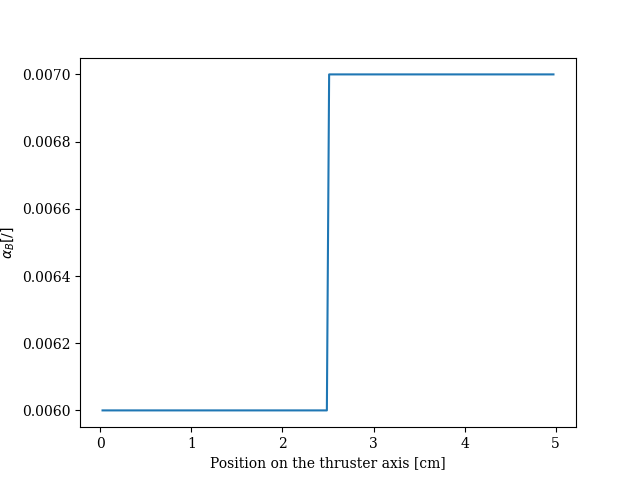

In [7]:
%matplotlib widget
config = path +'/data_-5_5/Configuration.cfg'
read_input_and_set_globals(config)
if AlphaModel == 'Step' :
    x_label = r"$\alpha$ channel"
    y_label = r"$\alpha$ plume"
elif AlphaModel == 'Linear' :
    x_label = r"$\alpha$ inlet"
    y_label = r"$\alpha$ outlet"
Results = path + "/data_"+str(indx)+"_"+str(indy)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"
if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
plt.figure()
plt.plot (100*x_center, alpha_B())
plt.xlabel('Position on the thruster axis [cm]')
plt.ylabel(r'$\alpha_B [/]$')
plt.show()
plt.savefig("Post_treat_1D/"+Model+"_alpha.png", dpi=300, transparent=True, bbox_inches='tight')
alpha_B1 = alpha_B1_save
alpha_B2 = alpha_B2_save

## CURRENT

Optimal case - alphaB1 : 0.0062, alphaB2 : 0.0066, Current : 3.3294585408924 [A], Relative error : -0.01626003326126312 [%]
Worst case - alphaB1 : 0.007, alphaB2 : 0.007, Current : 3.735078457904083 [A], Relative error : 12.164518255377871 [%]


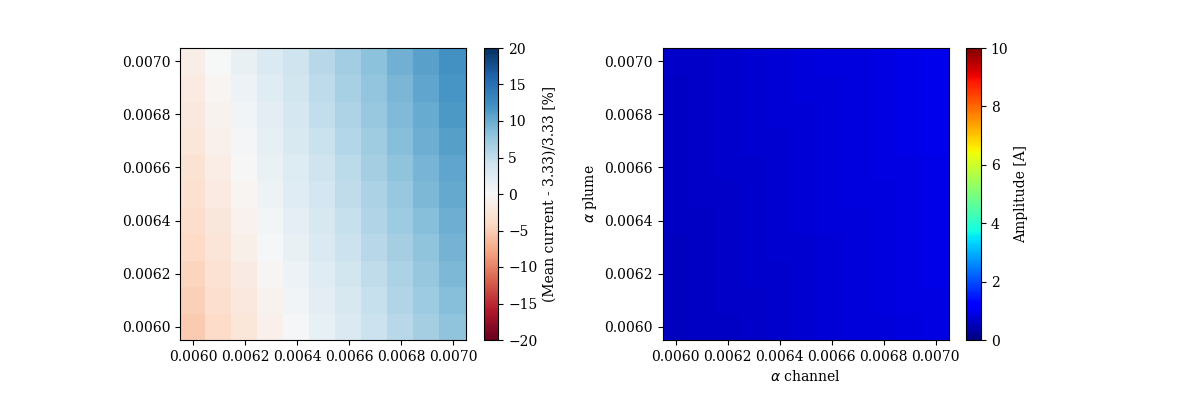

In [8]:
#Scaled value 
mean_curr_scaled = (mean_curr - Curr_ref)*100/Curr_ref
# Extreme cases
indx_opti = 0 # We look for the set of alphaB with the lowest error
indy_opti = 0
mean_curr_scaled_opti = 100
indx_worst = 0 # We look for the set of alphaB with the highest error
indy_worst = 0
mean_curr_scaled_worst = 0

for indx in range(-lungh,lungh+1):
    if Alpha_limit == True :
        for indy in range(indx,lungh+1):
            if abs(mean_curr_scaled[lungh+indx, lungh+indy]) < mean_curr_scaled_opti :
                indx_opti = indx
                indy_opti = indy
                mean_curr_scaled_opti = abs(mean_curr_scaled[lungh+indx, lungh+indy])
            elif abs(mean_curr_scaled[lungh+indx, lungh+indy]) > mean_curr_scaled_worst :
                indx_worst = indx
                indy_worst = indy
                mean_curr_scaled_worst = abs(mean_curr_scaled[lungh+indx, lungh+indy])
    elif Alpha_limit == False :
        for indy in range(-lungh,lungh+1):
            if abs(mean_curr_scaled[lungh+indx, lungh+indy]) < mean_curr_scaled_opti :
                indx_opti = indx
                indy_opti = indy
                mean_curr_scaled_opti = abs(mean_curr_scaled[lungh+indx, lungh+indy])
            elif abs(mean_curr_scaled[lungh+indx, lungh+indy]) > mean_curr_scaled_worst :
                indx_worst = indx
                indy_worst = indy
                mean_curr_scaled_worst = abs(mean_curr_scaled[lungh+indx, lungh+indy])
print("Optimal case - alphaB1 : "+str(alpha_B1[lungh+indx_opti])+", alphaB2 : "+str(alpha_B2[lungh+indy_opti])+", Current : "+str(mean_curr[lungh+indx_opti, lungh+indy_opti])+" [A], Relative error : "+str(mean_curr_scaled[lungh+indx_opti, lungh+indy_opti])+" [%]")
print("Worst case - alphaB1 : "+str(alpha_B1[lungh+indx_worst])+", alphaB2 : "+str(alpha_B2[lungh+indy_worst])+", Current : "+str(mean_curr[lungh+indx_worst, lungh+indy_worst])+" [A], Relative error : "+str(mean_curr_scaled[lungh+indx_worst][lungh+indy_worst])+" [%]")
RESULTS_OPTIMAL.append(["Optimal case current - alphaB1 : "+str(alpha_B1[lungh+indx_opti])+", alphaB2 : "+str(alpha_B2[lungh+indy_opti])+", Current : "+str(mean_curr[lungh+indx_opti, lungh+indy_opti])+" [A], Relative error : "+str(mean_curr_scaled[lungh+indx_opti, lungh+indy_opti])+" [%]"])
RESULTS_OPTIMAL.append(["Worst case current - alphaB1 : "+str(alpha_B1[lungh+indx_worst])+", alphaB2 : "+str(alpha_B2[lungh+indy_worst])+", Current : "+str(mean_curr[lungh+indx_worst, lungh+indy_worst])+" [A], Relative error : "+str(mean_curr_scaled[lungh+indx_worst][lungh+indy_worst])+" [%]"])

# Error grid

plt.figure(figsize=(12, 4))  # Set figure size
gs1 = gridspec.GridSpec(1, 2)
gs1.update(hspace=0.4, wspace=0.35, left=0.15, right=0.85, bottom=0.15)
ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])
assi = [ax0, ax1]


vmax = 10*(int(abs(mean_curr_scaled[lungh+indx_worst][lungh+indy_worst])/10)+1) # Calibrate the color chart
vmin = -vmax

im = ax0.pcolor(alpha_B1, alpha_B2, mean_curr_scaled.T, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = "(Mean current - " + str(Curr_ref) + ")/"+str(Curr_ref) +" [%]")
plt.xlabel(x_label)
plt.ylabel(y_label)

vmax=10
vmin=0
im = ax1.pcolor(alpha_B1, alpha_B2, std_curr.T, cmap='jet', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = "Amplitude [A]")
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/current_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/current.png", dpi=300, transparent=True, bbox_inches='tight')



## THRUST

Optimal case - alpha_B1 : 0.007, alpha_B2 : 0.007, Thrust : 0.048942034066641514 [N], Relative error : -0.11829782318058739 [%]
Worst case - alpha_B1 : 0.0061, alpha_B2 : 0.0061, Thrust : 0.043155464701859006 [N], Relative error : -11.927623057430603 [%]


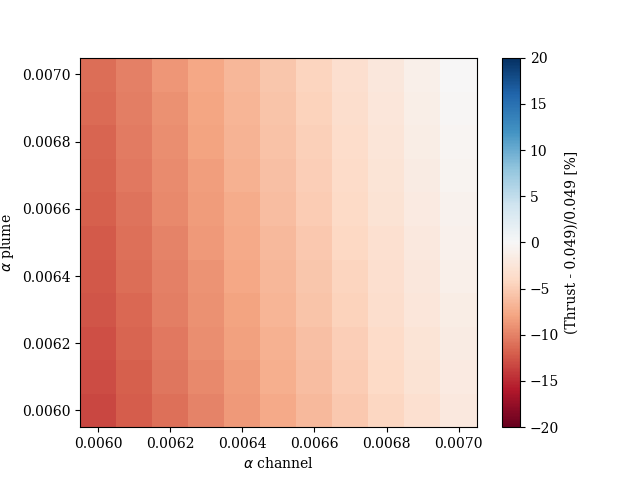

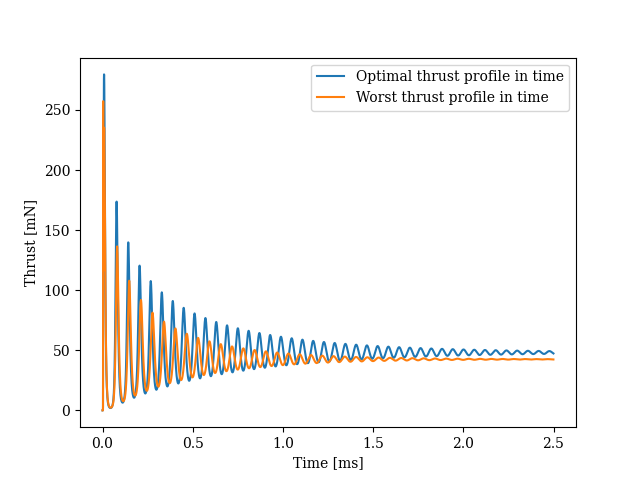

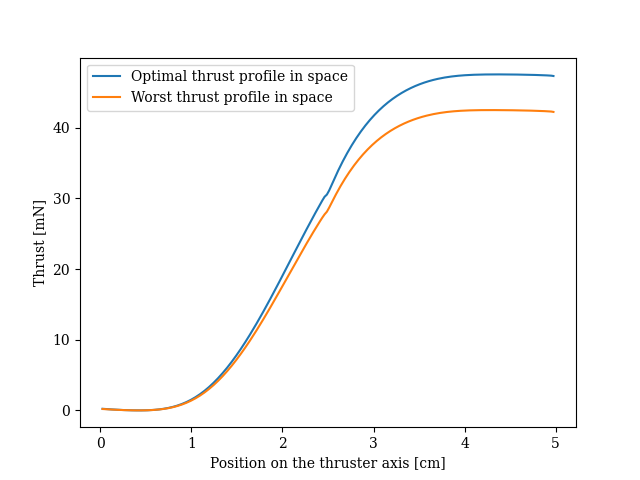

In [9]:
Thrust = np.zeros((2*lungh+1, 2*lungh+1))

# Thrust computation
for indx in range(-lungh,lungh+1):
    for indy in range(-lungh,lungh+1):
        ni_tot = []
        vi_tot = []
        ni_temp = []
        vi_temp = []
        time_save = []
        t_tot = 0
        ni_av = 0
        vi_av = 0
        Results = path + "/data_"+str(indx)+"_"+str(indy)
        ResultsFigs = Results+"/Figs"
        ResultsData = Results+"/Data"
        if not os.path.exists(ResultsFigs):
            os.makedirs(ResultsFigs)
        files       = glob.glob(ResultsData + "/*.pkl")
        for i_save, file in enumerate(files):
            with open(file, 'rb') as f:
                [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
                time_save.append(t)
                ni_tot.append(P[1,:])
                vi_tot.append(P[2,:])
        for i in range (len(vi_tot)):
            ni_temp.append(np.mean(ni_tot[i][-10:-3]))
            vi_temp.append(np.mean(vi_tot[i][-10:-3]))
        time_scale = np.linspace(0, time_save[-1], len(time_save)*2+1)
        ni_av = np.mean(np.interp(time_scale, time_save, ni_temp))
        vi_av = np.mean(np.interp(time_scale, time_save, vi_temp))
        Thrust[indx+lungh][indy+lungh] = M*A0*ni_av*vi_av**2

# Scaled value
Thrust_scaled = (Thrust - Thrust_ref)*100/Thrust_ref

# Extremal cases
indx_opti = 0 # We look for the set of alphaB with the lowest error
indy_opti = 0
thrust_scaled_opti = 100
indx_worst = 0 # We look for the set of alphaB with the highest error
indy_worst = 0
thrust_scaled_worst = 0
for indx in range(-lungh,lungh+1):
    if Alpha_limit == True :
        for indy in range(indx,lungh+1):
            if abs(Thrust_scaled[lungh+indx, lungh+indy]) < thrust_scaled_opti :
                indx_opti = indx
                indy_opti = indy
                thrust_scaled_opti = abs(Thrust_scaled[lungh+indx, lungh+indy])
            elif abs(Thrust_scaled[lungh+indx, lungh+indy]) > thrust_scaled_worst :
                indx_worst = indx
                indy_worst = indy
                thrust_scaled_worst = abs(Thrust_scaled[lungh+indx, lungh+indy])
    elif Alpha_limit == False :
        for indy in range(-lungh,lungh+1):
            if abs(Thrust_scaled[lungh+indx, lungh+indy]) < thrust_scaled_opti :
                indx_opti = indx
                indy_opti = indy
                thrust_scaled_opti = abs(Thrust_scaled[lungh+indx, lungh+indy])
            elif abs(Thrust_scaled[lungh+indx, lungh+indy]) > thrust_scaled_worst :
                indx_worst = indx
                indy_worst = indy
                thrust_scaled_worst = abs(Thrust_scaled[lungh+indx, lungh+indy])
print("Optimal case - alpha_B1 : " +str(alpha_B1[lungh+indx_opti])+ ", alpha_B2 : " +str(alpha_B2[lungh+indy_opti])+", Thrust : "+str(Thrust[lungh+indx_opti, lungh+indy_opti])+" [N], Relative error : "+str(Thrust_scaled[lungh+indx_opti, lungh+indy_opti])+" [%]")
print("Worst case - alpha_B1 : " +str(alpha_B1[lungh+indx_worst])+ ", alpha_B2 : " +str(alpha_B2[lungh+indy_worst])+", Thrust : "+str(Thrust[lungh+indx_worst, lungh+indy_worst])+" [N], Relative error : "+str(Thrust_scaled[lungh+indx_worst, lungh+indy_worst])+" [%]")
RESULTS_OPTIMAL.append(["Optimal case thrust - alpha_B1 : " +str(alpha_B1[lungh+indx_opti])+ ", alpha_B2 : " +str(alpha_B2[lungh+indy_opti])+", Thrust : "+str(Thrust[lungh+indx_opti, lungh+indy_opti])+" [N], Relative error : "+str(Thrust_scaled[lungh+indx_opti, lungh+indy_opti])+" [%]"])
RESULTS_OPTIMAL.append(["Worst case thrust - alpha_B1 : " +str(alpha_B1[lungh+indx_worst])+ ", alpha_B2 : " +str(alpha_B2[lungh+indy_worst])+", Thrust : "+str(Thrust[lungh+indx_worst, lungh+indy_worst])+" [N], Relative error : "+str(Thrust_scaled[lungh+indx_worst, lungh+indy_worst])+" [%]"])

# Error grid 
gs1 = gridspec.GridSpec(1, 2)
gs1.update(hspace=0.4, wspace=0.35, left=0.15, right=0.85, bottom=0.15)
f, ax0 = plt.subplots()
assi = [ax0]

vmax = 10*(int(abs(Thrust_scaled[lungh+indx_worst][lungh+indy_worst])/10)+1) # Calibrate the color chart
vmin = -vmax

im = ax0.pcolor(alpha_B1, alpha_B2, Thrust_scaled.T, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = "(Thrust - " +str(Thrust_ref)+")/"+str(Thrust_ref)+" [%]")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/thrust_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/thrust.png", dpi=300, transparent=True, bbox_inches='tight')

# Variations in time
plt.figure()
Thrust_profile_opti = []
ni_tot = []
vi_tot = []
time_save = []
Results = path + "/data_"+str(indx_opti)+"_"+str(indy_opti)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
for i in range(len(vi_tot)) :
    Thrust_profile_opti.append(np.mean(M*A0*ni_tot[i][-10:-3]*vi_tot[i][-10:-3]**2))
for i in range (len(time_save)):
    time_save[i]=1000*time_save[i] # We convert to ms
    Thrust_profile_opti[i]=1000*Thrust_profile_opti[i] # We convert the thrust profile to mN
plt.plot(time_save, Thrust_profile_opti ,label = 'Optimal thrust profile in time')
Thrust_profile_worst = []
ni_tot = []
vi_tot = []
time_save = []
Results = path + "/data_"+str(indx_worst)+"_"+str(indy_worst)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
for i in range(len(vi_tot)) :
    Thrust_profile_worst.append(np.mean(M*A0*ni_tot[i][-10:-3]*vi_tot[i][-10:-3]**2))
for i in range (len(time_save)):
    time_save[i]=1000*time_save[i] # We convert to ms
    Thrust_profile_worst[i]=1000*Thrust_profile_worst[i] # We convert the thrust profile to mN
plt.plot(time_save, Thrust_profile_worst ,label = 'Worst thrust profile in time')
plt.legend()
plt.xlabel('Time [ms]')
plt.ylabel('Thrust [mN]')
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/thrust_extre_time_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/thrust_extre_time.png", dpi=300, transparent=True, bbox_inches='tight')

# Variations in space
plt.figure()
Thrust_profile_opti = []
ni_tot = []
vi_tot = []
Results = path + "/data_"+str(indx_opti)+"_"+str(indy_opti)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
for i in range(len(vi_tot[0])) :
    Thrust_profile_opti.append(np.mean(M*A0*ni_tot[-100][i]*vi_tot[-100][i]**2))
for i in range (len(x_center)):
    x_center[i]=100*x_center[i] # We convert to cm
    Thrust_profile_opti[i]=1000*Thrust_profile_opti[i] # We convert the thrust profile to mN
plt.plot(x_center, Thrust_profile_opti ,label = 'Optimal thrust profile in space')
Thrust_profile_worst = []
ni_tot = []
vi_tot = []
Results = path + "/data_"+str(indx_worst)+"_"+str(indy_worst)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
for i in range(len(vi_tot[0])) :
    Thrust_profile_worst.append(np.mean(M*A0*ni_tot[-100][i]*vi_tot[-100][i]**2))
for i in range (len(x_center)):
    x_center[i]=100*x_center[i] # We convert to cm
    Thrust_profile_worst[i]=1000*Thrust_profile_worst[i] # We convert the thrust profile to mN
plt.plot(x_center,Thrust_profile_worst ,label = 'Worst thrust profile in space')
plt.legend()
plt.xlabel('Position on the thruster axis [cm]')
plt.ylabel('Thrust [mN]')
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/thrust_extre_space_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/thrust_extre_space.png", dpi=300, transparent=True, bbox_inches='tight')




## ISP

Optimal case - alphaB1 : 0.007, alphaB2 : 0.007, ISP : 1736.8820337606762 [s], Relative error : 2.4709164460575943 [%]
Worst case - alphaB1 : 0.0061, alphaB2 : 0.0061, ISP : 1751.7755019976853 [s], Relative error : 3.3495871385065072 [%]


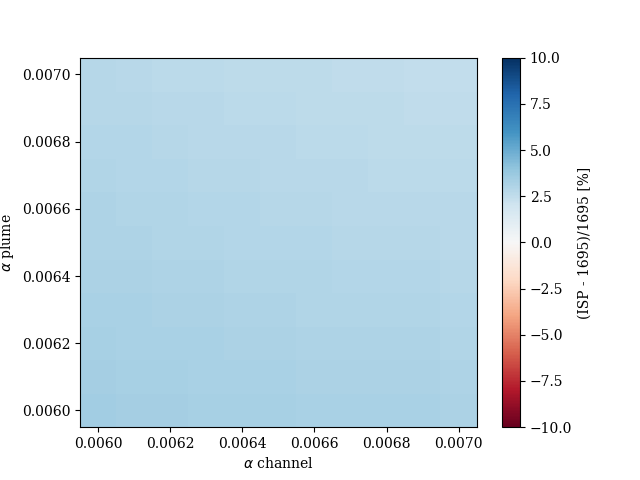

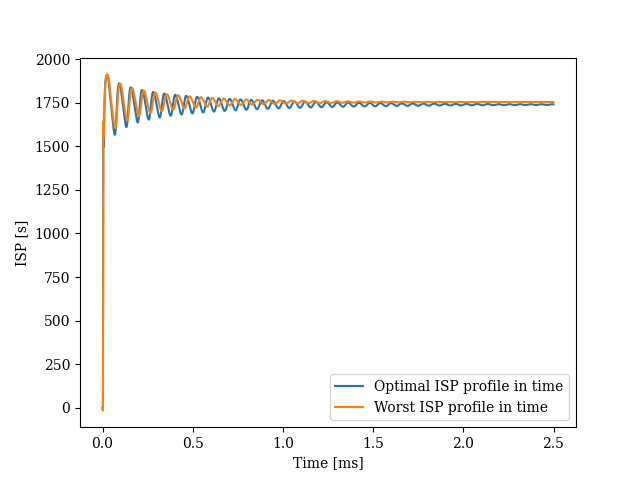

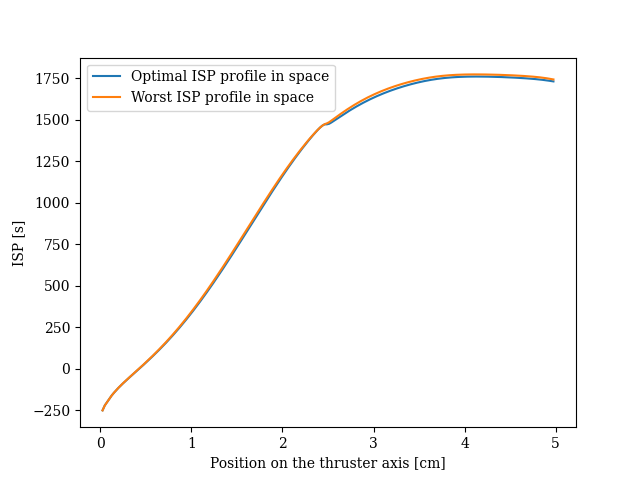

In [10]:
g        = phy_const.g

ISP = np.zeros((2*lungh+1, 2*lungh+1))

# ISP calculation
for indx in range(-lungh,lungh+1):
    for indy in range(-lungh,lungh+1):
        t_tot = 0
        time_save = []
        vi_tot = []
        vi_av = 0
        vi_temp = []
        Results = path + "/data_"+str(indx)+"_"+str(indy)
        ResultsFigs = Results+"/Figs"
        ResultsData = Results+"/Data"
        if not os.path.exists(ResultsFigs):
            os.makedirs(ResultsFigs)
        files       = glob.glob(ResultsData + "/*.pkl")
        for i_save, file in enumerate(files):
            with open(file, 'rb') as f:
                [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
                time_save.append(t)
                vi_tot.append(P[2,:])
        for i in range(len(vi_tot)) :
            vi_temp.append(np.mean(vi_tot[i][-10:-3]))
        time_scale = np.linspace(0, time_save[-1], len(time_save)*2+1)
        vi_av = np.mean(np.interp(time_scale, time_save, vi_temp))
        ISP[indx+lungh][indy+lungh] = vi_av/g
        
# Scaled value
ISP_scaled = (ISP - ISP_ref)*100/ISP_ref

# Extremal cases
indx_opti = 0 # We look for the set of alphaB with the lowest error
indy_opti = 0
isp_scaled_opti = 100
indx_worst = 0 # We look for the set of alphaB with the highest error
indy_worst = 0
isp_scaled_worst = 0
for indx in range(-lungh,lungh+1):
    if Alpha_limit == True :
        for indy in range(indx,lungh+1):
            if abs(ISP_scaled[lungh+indx, lungh+indy]) < isp_scaled_opti :
                indx_opti = indx
                indy_opti = indy
                isp_scaled_opti = abs(ISP_scaled[lungh+indx, lungh+indy])
            elif abs(ISP_scaled[lungh+indx, lungh+indy]) > isp_scaled_worst :
                indx_worst = indx
                indy_worst = indy
                isp_scaled_worst = abs(ISP_scaled[lungh+indx, lungh+indy])
    elif Alpha_limit == False :
        for indy in range(-lungh,lungh+1):
            if abs(ISP_scaled[lungh+indx, lungh+indy]) < isp_scaled_opti :
                indx_opti = indx
                indy_opti = indy
                isp_scaled_opti = abs(ISP_scaled[lungh+indx, lungh+indy])
            elif abs(ISP_scaled[lungh+indx, lungh+indy]) > isp_scaled_worst :
                indx_worst = indx
                indy_worst = indy
                isp_scaled_worst = abs(ISP_scaled[lungh+indx, lungh+indy])
print("Optimal case - alphaB1 : "+str(alpha_B1[lungh+indx_opti])+", alphaB2 : " +str(alpha_B2[lungh+indy_opti])+", ISP : "+str(ISP[lungh+indx_opti, lungh+indy_opti])+" [s], Relative error : "+str(ISP_scaled[lungh+indx_opti, lungh+indy_opti])+ " [%]")
print("Worst case - alphaB1 : "+str(alpha_B1[lungh+indx_worst])+", alphaB2 : "+str(alpha_B2[lungh+indy_worst])+", ISP : "+str(ISP[lungh+indx_worst, lungh+indy_worst])+" [s], Relative error : "+str(ISP_scaled[lungh+indx_worst, lungh+indy_worst])+ " [%]")
RESULTS_OPTIMAL.append(["Optimal case ISP - alphaB1 : "+str(alpha_B1[lungh+indx_opti])+", alphaB2 : " +str(alpha_B2[lungh+indy_opti])+", ISP : "+str(ISP[lungh+indx_opti, lungh+indy_opti])+" [s], Relative error : "+str(ISP_scaled[lungh+indx_opti, lungh+indy_opti])+ " [%]"])
RESULTS_OPTIMAL.append(["Worst case ISP - alphaB1 : "+str(alpha_B1[lungh+indx_worst])+", alphaB2 : "+str(alpha_B2[lungh+indy_worst])+", ISP : "+str(ISP[lungh+indx_worst, lungh+indy_worst])+" [s], Relative error : "+str(ISP_scaled[lungh+indx_worst, lungh+indy_worst])+ " [%]"])

# Error grid
gs1 = gridspec.GridSpec(1, 2)
gs1.update(hspace=0.4, wspace=0.35, left=0.15, right=0.85, bottom=0.15)
f, ax0 = plt.subplots()
assi = [ax0]

vmax = 10*(int(abs(ISP_scaled[lungh+indx_worst][lungh+indy_worst])/10)+1) # Calibrate the color chart
vmin = -vmax

im = ax0.pcolor(alpha_B1, alpha_B2, ISP_scaled.T, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = "(ISP - "+ str(ISP_ref) +")/"+str(ISP_ref)+" [%]")
plt.xlabel(x_label)
plt.ylabel(y_label)
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/ISP_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/ISP.png", dpi=300, transparent=True, bbox_inches='tight')



# Time variations

plt.figure()

ISP_profile_opti = []
vi_tot = []
time_save = []
Results = path + "/data_"+str(indx_opti)+"_"+str(indy_opti)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        vi_tot.append(P[2,:])
for i in range(len(vi_tot)) :
    ISP_profile_opti.append(np.mean(vi_tot[i][-10:-3]/g))
for i in range (len(time_save)):
    time_save[i]=1000*time_save[i]
plt.plot(time_save, ISP_profile_opti ,label = 'Optimal ISP profile in time')
ISP_profile_worst = []
ni_tot = []
vi_tot = []
time_save = []
Results = path + "/data_"+str(indx_worst)+"_"+str(indy_worst)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
for i in range(len(vi_tot)) :
    ISP_profile_worst.append(np.mean(vi_tot[i][-10:-3]/g))
for i in range (len(time_save)):
    time_save[i]=1000*time_save[i]
plt.plot(time_save, ISP_profile_worst ,label = 'Worst ISP profile in time')
plt.legend()
plt.xlabel('Time [ms]')
plt.ylabel('ISP [s]')
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/ISP_extre_time_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/ISP_extre_time.png", dpi=300, transparent=True, bbox_inches='tight')

# Space variations

plt.figure()

ISP_profile_opti = []
vi_tot = []
Results = path + "/data_"+str(indx_opti)+"_"+str(indy_opti)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        vi_tot.append(P[2,:])
for i in range(len(vi_tot[0])) :
    ISP_profile_opti.append(np.mean(vi_tot[-100][i]/g))
for i in range (len(x_center)):
    x_center[i]=100*x_center[i]
plt.plot(x_center, ISP_profile_opti ,label = 'Optimal ISP profile in space')
ISP_profile_worst = []
ni_tot = []
vi_tot = []
Results = path + "/data_"+str(indx_worst)+"_"+str(indy_worst)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
for i in range(len(vi_tot[0])) :
    ISP_profile_worst.append(np.mean(vi_tot[-100][i]/g))
for i in range (len(x_center)):
    x_center[i]=100*x_center[i]
plt.plot(x_center, ISP_profile_worst ,label = 'Worst ISP profile in space')
plt.legend()
plt.xlabel('Position on the thruster axis [cm]')
plt.ylabel('ISP [s]')
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/ISP_extre_space_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/ISP_extre_space.png", dpi=300, transparent=True, bbox_inches='tight')

## MASS EFFICIENCY

Optimal case - alphaB1 : 0.006, alphaB2 : 0.006, eta : 47.704766378026854 [%], Relative error : 19.261915945067134 [%]
Worst case - alphaB1 : 0.007, alphaB2 : 0.007, eta : 55.39811724954933 [%], Relative error : 38.495293123873324 [%]


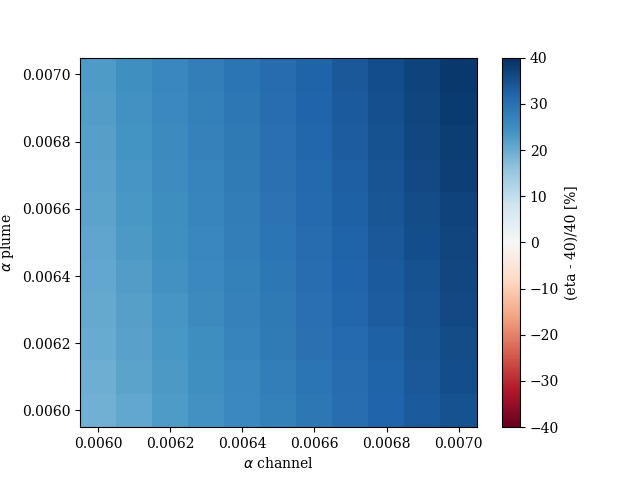

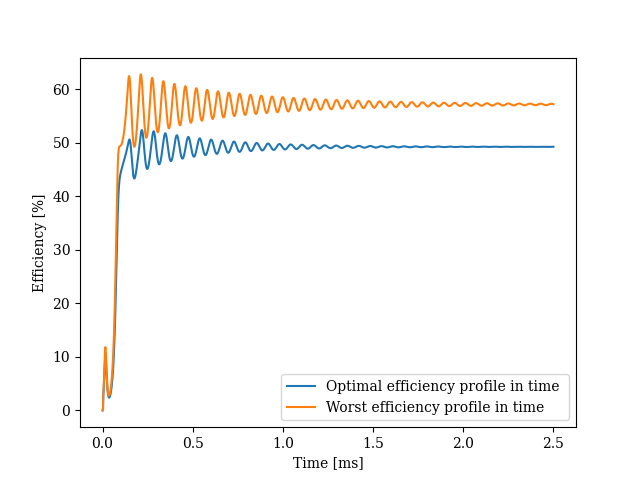

In [11]:
eta = np.zeros((2*lungh+1, 2*lungh+1))


# Efficiency calculation
for indx in range(-lungh,lungh+1):
    for indy in range(-lungh,lungh+1):
        ng_tot = []
        ng_av_out = 0
        ng_av_in = 0
        ng_temp_in = []
        ng_temp_out = []
        t_tot = 0
        time_save = []
        Results = path + "/data_"+str(indx)+"_"+str(indy)
        ResultsFigs = Results+"/Figs"
        ResultsData = Results+"/Data"
        if not os.path.exists(ResultsFigs):
            os.makedirs(ResultsFigs)
        files       = glob.glob(ResultsData + "/*.pkl")
        for i_save, file in enumerate(files):
            with open(file, 'rb') as f:
                [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
                ng_tot.append(P[0,:])
                time_save.append(t)
        for i in range (len(ng_tot)) :
            ng_temp_out.append(np.mean(ng_tot[i][-10:-3]))
            ng_temp_in.append(np.mean(ng_tot[i][3:10]))
        time_scale = np.linspace(0, time_save[-1], len(time_save)*2+1)
        ng_av_out = np.mean(np.interp(time_scale, time_save, ng_temp_out))
        ng_av_in = np.mean(np.interp(time_scale, time_save, ng_temp_in))
        eta[indx+lungh][indy+lungh] = (1-(ng_av_out)/(ng_av_in))*100
        
# Scaled variable
eta_scaled = (eta - Eta_ref)*100/Eta_ref

# Extremal cases
indx_opti = 0 # We look for the set of alphaB with the lowest error
indy_opti = 0
eta_scaled_opti = 100
indx_worst = 0 # We look for the set of alphaB with the highest error
indy_worst = 0
eta_scaled_worst = 0
for indx in range(-lungh,lungh+1):
    if Alpha_limit == True :
        for indy in range(indx,lungh+1):
            if abs(eta_scaled[lungh+indx, lungh+indy]) < eta_scaled_opti :
                indx_opti = indx
                indy_opti = indy
                eta_scaled_opti = abs(eta_scaled[lungh+indx, lungh+indy])
            elif abs(eta_scaled[lungh+indx, lungh+indy]) > eta_scaled_worst :
                indx_worst = indx
                indy_worst = indy
                eta_scaled_worst = abs(eta_scaled[lungh+indx, lungh+indy])
    elif Alpha_limit == False :
        for indy in range(-lungh,lungh+1):
            if abs(eta_scaled[lungh+indx, lungh+indy]) < eta_scaled_opti :
                indx_opti = indx
                indy_opti = indy
                eta_scaled_opti = abs(eta_scaled[lungh+indx, lungh+indy])
            elif abs(eta_scaled[lungh+indx, lungh+indy]) > eta_scaled_worst :
                indx_worst = indx
                indy_worst = indy
                eta_scaled_worst = abs(eta_scaled[lungh+indx, lungh+indy])
print("Optimal case - alphaB1 : "+str(alpha_B1[lungh+indx_opti])+", alphaB2 : " +str(alpha_B2[lungh+indy_opti])+", eta : "+str(eta[lungh+indx_opti, lungh+indy_opti])+" [%], Relative error : "+str(eta_scaled[lungh+indx_opti, lungh+indy_opti])+ " [%]")
print("Worst case - alphaB1 : "+str(alpha_B1[lungh+indx_worst])+", alphaB2 : "+str(alpha_B2[lungh+indy_worst])+", eta : "+str(eta[lungh+indx_worst, lungh+indy_worst])+" [%], Relative error : "+str(eta_scaled[lungh+indx_worst, lungh+indy_worst])+ " [%]")
RESULTS_OPTIMAL.append(["Optimal case eta - alphaB1 : "+str(alpha_B1[lungh+indx_opti])+", alphaB2 : " +str(alpha_B2[lungh+indy_opti])+", eta : "+str(eta[lungh+indx_opti, lungh+indy_opti])+" [%], Relative error : "+str(eta_scaled[lungh+indx_opti, lungh+indy_opti])+ " [%]"])
RESULTS_OPTIMAL.append(["Worst case eta - alphaB1 : "+str(alpha_B1[lungh+indx_worst])+", alphaB2 : "+str(alpha_B2[lungh+indy_worst])+", eta : "+str(eta[lungh+indx_worst, lungh+indy_worst])+" [%], Relative error : "+str(eta_scaled[lungh+indx_worst, lungh+indy_worst])+ " [%]"])


# Error grid
gs1 = gridspec.GridSpec(1, 2)
gs1.update(hspace=0.4, wspace=0.35, left=0.15, right=0.85, bottom=0.15)
f, ax0 = plt.subplots()
assi = [ax0]

vmax = 10*(int(abs(eta_scaled[lungh+indx_worst][lungh+indy_worst])/10)+1) # Calibrate the color chart
vmin = -vmax

im = ax0.pcolor(alpha_B1, alpha_B2, eta_scaled.T, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = "(eta - "+str(Eta_ref)+")/"+str(Eta_ref)+" [%]")
plt.xlabel(x_label)
plt.ylabel(y_label)
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/eta_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/eta.png", dpi=300, transparent=True, bbox_inches='tight')
    
# Time variations

plt.figure()

eta_profile_opti = []
ng_tot = []
time_save = []
Results = path + "/data_"+str(indx_opti)+"_"+str(indy_opti)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        ng_tot.append(P[0,:])
for i in range(len(ng_tot)) :
    eta_profile_opti.append(100*(1-(np.mean(ng_tot[i][-10:-3])/np.mean(ng_tot[i][3:10]))))
for i in range (len(time_save)):
    time_save[i]=1000*time_save[i]
plt.plot(time_save, eta_profile_opti ,label = 'Optimal efficiency profile in time ')

eta_profile_worst = []
ng_tot = []
time_save = []
Results = path + "/data_"+str(indx_worst)+"_"+str(indy_worst)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        ng_tot.append(P[0,:])
for i in range(len(ng_tot)) :
    eta_profile_worst.append(100*(1-(np.mean(ng_tot[i][-10:-3])/np.mean(ng_tot[i][3:10]))))
    pass
for i in range (len(time_save)):
    time_save[i]=1000*time_save[i]
plt.plot(time_save, eta_profile_worst ,label = 'Worst efficiency profile in time')
plt.legend()
plt.xlabel('Time [ms]')
plt.ylabel('Efficiency [%]')
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/eta_extre_time_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/eta_extre_time.png", dpi=300, transparent=True, bbox_inches='tight')

## VARIABLES PROFILE

Optimal case - alphaB1 : 0.0061, alphaB2 : 0.007, Mean relative error : 9.331927214827044 [%]
Worst case - alphaB1 : 0.007, alphaB2 : 0.007, Mean relative error : 13.312256412122345 [%]


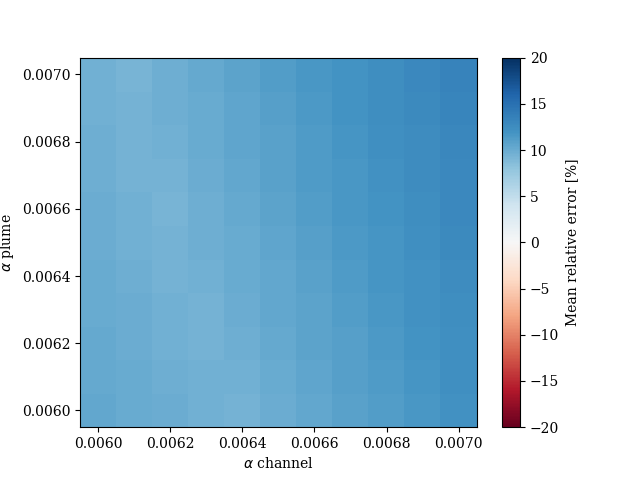

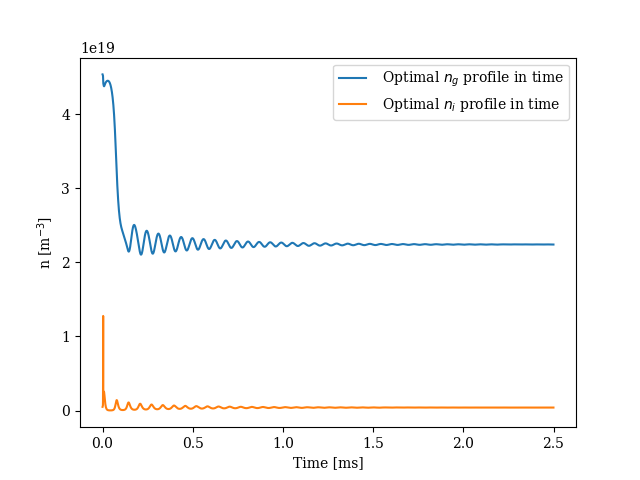

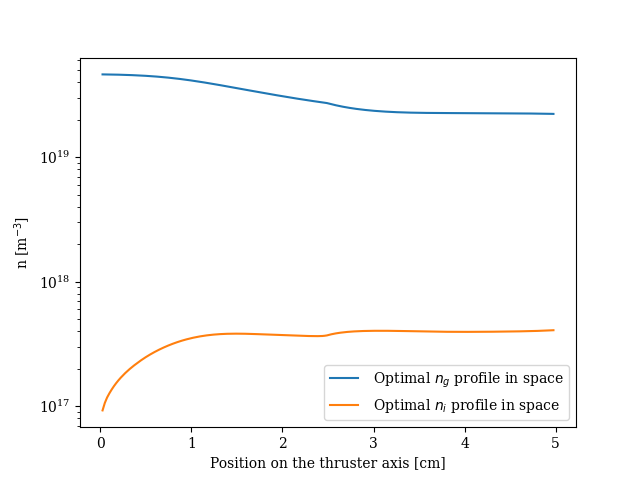

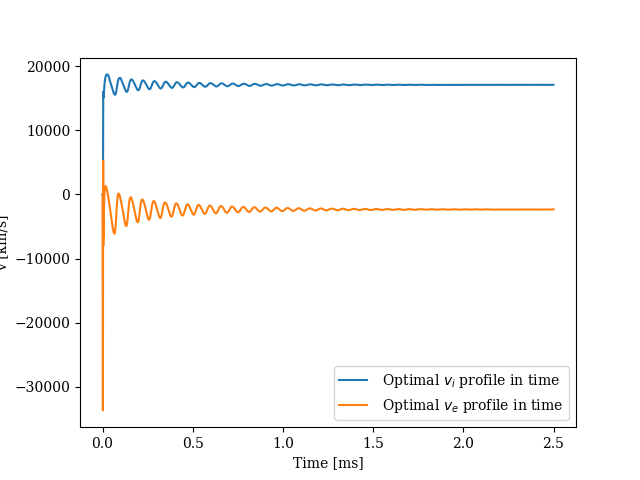

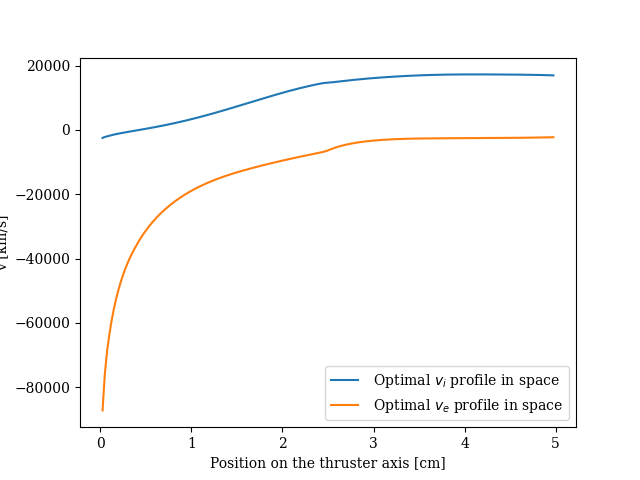

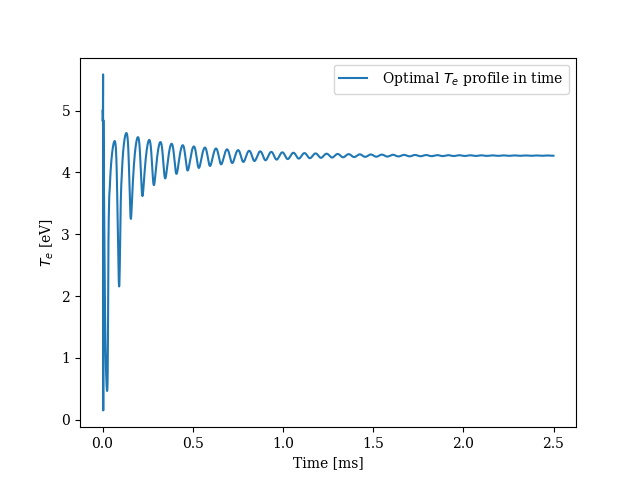

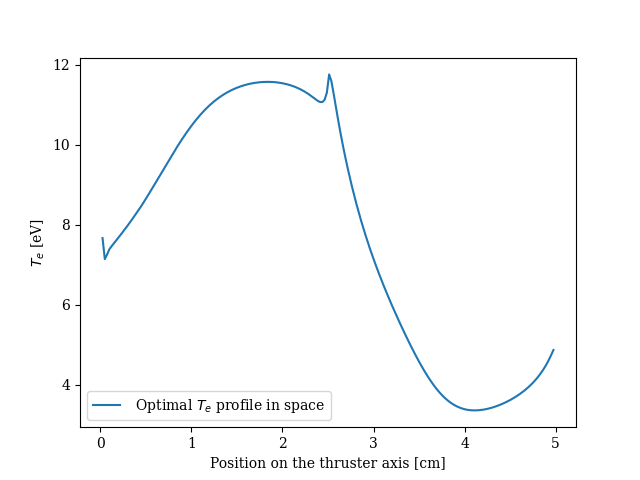

In [12]:
mean_error = (1/4)*(abs(mean_curr_scaled)+abs(Thrust_scaled)+abs(ISP_scaled)+abs(eta_scaled))

# Efficiency calculation
indx_opti = 0 # We look for the set of alphaB with the lowest error
indy_opti = 0
mean_error_opti = 100
indx_worst = 0 # We look for the set of alphaB with the highest error
indy_worst = 0
mean_error_worst = 0
for indx in range(-lungh,lungh+1):
    if Alpha_limit == True :
        for indy in range(indx,lungh+1):
            if abs(mean_error[lungh+indx, lungh+indy]) < mean_error_opti :
                indx_opti = indx
                indy_opti = indy
                mean_error_opti = abs(mean_error[lungh+indx, lungh+indy])
            elif abs(mean_error[lungh+indx, lungh+indy]) > mean_error_worst :
                indx_worst = indx
                indy_worst = indy
                mean_error_worst = abs(mean_error[lungh+indx, lungh+indy])
    elif Alpha_limit == False :
        for indy in range(-lungh,lungh+1):
            if abs(mean_error[lungh+indx, lungh+indy]) < mean_error_opti :
                indx_opti = indx
                indy_opti = indy
                mean_error_opti = abs(mean_error[lungh+indx, lungh+indy])
            elif abs(mean_error[lungh+indx, lungh+indy]) > mean_error_worst :
                indx_worst = indx
                indy_worst = indy
                mean_error_worst = abs(mean_error[lungh+indx, lungh+indy])
print("Optimal case - alphaB1 : "+str(alpha_B1[lungh+indx_opti])+", alphaB2 : " +str(alpha_B2[lungh+indy_opti])+", Mean relative error : "+str(mean_error[lungh+indx_opti, lungh+indy_opti])+ " [%]")
print("Worst case - alphaB1 : "+str(alpha_B1[lungh+indx_worst])+", alphaB2 : "+str(alpha_B2[lungh+indy_worst])+", Mean relative error : "+str(mean_error[lungh+indx_worst, lungh+indy_worst])+ " [%]")
RESULTS_OPTIMAL.append(["Optimal case Overall - alphaB1 : "+str(alpha_B1[lungh+indx_opti])+", alphaB2 : " +str(alpha_B2[lungh+indy_opti])+", Mean relative error : "+str(mean_error[lungh+indx_opti, lungh+indy_opti])+ " [%]"])
RESULTS_OPTIMAL.append(["Worst case Overall - alphaB1 : "+str(alpha_B1[lungh+indx_worst])+", alphaB2 : "+str(alpha_B2[lungh+indy_worst])+", Mean relative error : "+str(mean_error[lungh+indx_worst, lungh+indy_worst])+ " [%]"])

#Error grid
gs1 = gridspec.GridSpec(1, 2)
gs1.update(hspace=0.4, wspace=0.35, left=0.15, right=0.85, bottom=0.15)
f, ax0 = plt.subplots()
assi = [ax0]

vmax = 10*(int(abs(mean_error[lungh+indx_worst][lungh+indy_worst])/10)+1) # Calibrate the color chart
vmin = -vmax


im = ax0.pcolor(alpha_B1, alpha_B2, mean_error.T, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = "Mean relative error [%]")
plt.xlabel(x_label)
plt.ylabel(y_label)
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal.png", dpi=300, transparent=True, bbox_inches='tight')

time_save = []
ng_tot = []
ng_time = []
ng_space = []
ni_tot = []
ni_time = []
ni_space = []
vi_tot = []
vi_time = []
vi_space = []
Te_tot = []
Te_time = []
Te_space = []
ve_tot = []
ve_time = []
ve_space = []
Results = path + "/data_"+str(indx_opti)+"_"+str(indy_opti)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        ng_tot.append(P[0,:])
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
        Te_tot.append(P[3,:])
        ve_tot.append(P[4,:])
for i in range(len(vi_tot)):
    ng_time.append(np.mean(ng_tot[i][-10:-3]))
    ni_time.append(np.mean(ni_tot[i][-10:-3]))
    vi_time.append(np.mean(vi_tot[i][-10:-3]))
    Te_time.append(np.mean(Te_tot[i][-10:-3]))
    ve_time.append(np.mean(ve_tot[i][-10:-3]))
for i in range(len(vi_tot[0])) :
    ng_space.append(np.mean(ng_tot[-100][i]))
    ni_space.append(np.mean(ni_tot[-100][i]))
    vi_space.append(np.mean(vi_tot[-100][i]))
    Te_space.append(np.mean(Te_tot[-100][i]))
    ve_space.append(np.mean(ve_tot[-100][i]))
for i in range (len(time_save)) :
    time_save[i]=1000* time_save[i]
for i in range (len(x_center)) :
    x_center[i]=100* x_center[i]
for i in range (len(vi_tot)):
    vi_tot[i]=vi_tot[i]/1000
for i in range (len(ve_tot)):
    ve_tot[i]=ve_tot[i]/1000
plt.figure()
plt.plot(time_save, ng_time ,label = r' Optimal $n_g$ profile in time')
plt.plot(time_save, ni_time ,label = r' Optimal $n_i$ profile in time')
plt.legend()
plt.xlabel('Time [ms]')
plt.ylabel(r'n [m$^{-3}$]')
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal_density_time_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal_density_time.png", dpi=300, transparent=True, bbox_inches='tight')
plt.figure()
plt.plot(x_center, ng_space ,label = r' Optimal $n_g$ profile in space')
plt.plot(x_center, ni_space ,label = r' Optimal $n_i$ profile in space')
plt.legend()
plt.xlabel('Position on the thruster axis [cm]')
plt.ylabel(r'n [m$^{-3}$]')
plt.yscale("log")
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal_density_space_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal_density_space.png", dpi=300, transparent=True, bbox_inches='tight')

plt.figure()
plt.plot(time_save, vi_time ,label = r' Optimal $v_i$ profile in time')
plt.plot(time_save, ve_time ,label = r' Optimal $v_e$ profile in time')
plt.legend()
plt.xlabel('Time [ms]')
plt.ylabel('v [km/s]')
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal_velocity_time_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal_velocity_time.png", dpi=300, transparent=True, bbox_inches='tight')
plt.figure()
plt.plot(x_center, vi_space ,label = r' Optimal $v_i$ profile in space')
plt.plot(x_center, ve_space ,label = r' Optimal $v_e$ profile in space')
plt.legend()
plt.xlabel('Position on the thruster axis [cm]')
plt.ylabel('v [km/s]')
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal_velocity_space_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal_velocity_space.png", dpi=300, transparent=True, bbox_inches='tight')

plt.figure()
plt.plot(time_save, Te_time ,label = r' Optimal $T_e$ profile in time')
plt.legend()
plt.xlabel('Time [ms]')
plt.ylabel(r'$T_e$ [eV]')
plt.figure()
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal_temperature_time_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal.png", dpi=300, transparent=True, bbox_inches='tight')
plt.plot(x_center, Te_space ,label = r' Optimal $T_e$ profile in space')
plt.legend()
plt.xlabel('Position on the thruster axis [cm]')
plt.ylabel(r'$T_e$ [eV]')
if Alpha_limit == True :
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal_temperature_space_limited.png", dpi=300, transparent=True, bbox_inches='tight')
elif Alpha_limit == False : 
    plt.savefig("Post_treat_1D/"+Thruster+"/"+Model+"/optimal_temperature_space.png", dpi=300, transparent=True, bbox_inches='tight')

## OPTIMAL RESULTS

In [13]:
print(RESULTS_OPTIMAL)

[['Optimal case current - alphaB1 : 0.0062, alphaB2 : 0.0066, Current : 3.3294585408924 [A], Relative error : -0.01626003326126312 [%]'], ['Worst case current - alphaB1 : 0.007, alphaB2 : 0.007, Current : 3.735078457904083 [A], Relative error : 12.164518255377871 [%]'], ['Optimal case thrust - alpha_B1 : 0.007, alpha_B2 : 0.007, Thrust : 0.048942034066641514 [N], Relative error : -0.11829782318058739 [%]'], ['Worst case thrust - alpha_B1 : 0.0061, alpha_B2 : 0.0061, Thrust : 0.043155464701859006 [N], Relative error : -11.927623057430603 [%]'], ['Optimal case ISP - alphaB1 : 0.007, alphaB2 : 0.007, ISP : 1736.8820337606762 [s], Relative error : 2.4709164460575943 [%]'], ['Worst case ISP - alphaB1 : 0.0061, alphaB2 : 0.0061, ISP : 1751.7755019976853 [s], Relative error : 3.3495871385065072 [%]'], ['Optimal case eta - alphaB1 : 0.006, alphaB2 : 0.006, eta : 47.704766378026854 [%], Relative error : 19.261915945067134 [%]'], ['Worst case eta - alphaB1 : 0.007, alphaB2 : 0.007, eta : 55.3981

Results_1D/PPSX00K/Step/data_-5_-5



KeyboardInterrupt



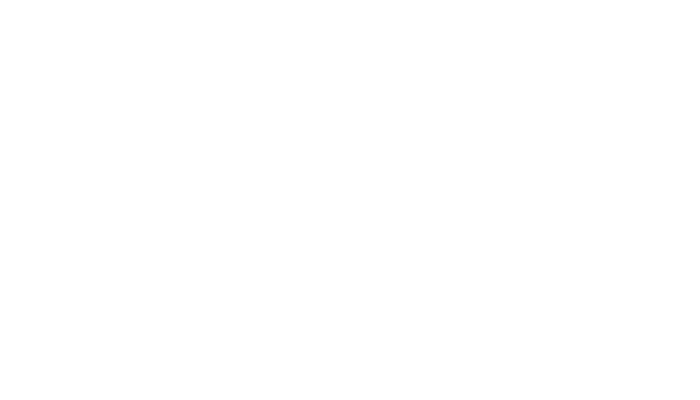

In [14]:
plt.figure(figsize=(7, 4))

for indx in range(-lungh,lungh+1):
    for indy in range(-lungh,lungh+1):
    # for indy in range(1, lungh+1):
        Results = path + "data_" + str(indx) + "_" + str(indy)
        print(Results)
        calc_current(Results)
        ResultConfig = Results+'/Configuration.cfg'
        read_input_and_set_globals(ResultConfig)
    
        time,Current,Voltage = np.loadtxt(Results + "/cur_volt.dat")
    
        plt.plot(time*1e3, Current, label = fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
plt.xlabel("Time [ms]")
plt.ylabel("Current [A]")
plt.grid(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0,10)
plt.xlim(0,2)
plt.tight_layout()
plt.show()

# plt.savefig("images_compare_Kel/currents.png", dpi=300, transparent=True)


## Ion current profiles

In [ ]:
for indx in range(-lungh,lungh+1):
    for indy in range(-lungh, lungh+1):
        fig = plt.figure(figsize=(10, 10))
        gls = fig.add_gridspec(4, 1, hspace=0.1)
        gls.update(left=0.15, right=0.65, wspace=0.05)
        ax0 = fig.add_subplot(gls[0])
        ax1 = fig.add_subplot(gls[1])
        ax2 = fig.add_subplot(gls[2])
        ax2t = ax2.twinx()
        ax3 = fig.add_subplot(gls[3])

        Results = path + "data_" + str(indx) + "_" + str(indy)
        calc_current(Results)
        ResultsData = Results + "/Data"
        files = get_files(ResultsData)
        read_input_and_set_globals(Results + "/Configuration.cfg")
    
   # i_save = -1
        ng = np.zeros(NBPOINTS)
        ni = np.zeros(NBPOINTS)
        vi = np.zeros(NBPOINTS)
        Te = np.zeros(NBPOINTS)
        ve = np.zeros(NBPOINTS)
    
        for i_save, file in enumerate(files[-10:]):
            with open(file, 'rb') as f:
                [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
                ng += P[0,:]
                ni += P[1,:]
                vi += P[2,:]
                Te += P[3,:]
                ve += P[4,:]
        ng /= (i_save+1)
        ni /= (i_save+1)
        vi /= (i_save+1)
        Te /= (i_save+1)
        ve /= (i_save+1)
    
        ax0.plot(x_center*100, ng, label = "$n_g$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
        ax0.plot(x_center*100, ni, label = "$n_i$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '--')
        ax1.plot(x_center*100, Te, label = "$T_e$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
        ax2.plot(x_center*100, vi, label = "$v_i$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '--')
        ax2t.plot(x_center*100, ve, label = "$v_e$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
        ax3.plot(x_center*100, phy_const.elementary_charge*ve*ni, label = "e, " + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = ':')
        ax3.plot(x_center*100, phy_const.elementary_charge*vi*ni, label = "i, " + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '--')
        ax3.plot(x_center*100, phy_const.elementary_charge*(vi-ve)*ni, label = "tot, " + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '-')
            
        ax0.set_ylabel(r'Density [m$^{-3}$]', fontsize=18)
        ax1.set_ylabel(r'Temperature [eV]', fontsize=18)
        ax2.set_ylabel(r'$v_i$ (dashed) [m/s]', fontsize=18)
        ax2t.set_ylabel(r'$v_e$ [m/s]', fontsize=18)
        ax3.set_xlabel(r'$x$ [cm]', fontsize=18)
        ax3.set_ylabel(r'$J$ [A/m$^2$]', fontsize=18)
        
        
        ax0.set_xlim(0, 5)
        ax1.set_xlim(0, 5)
        ax2.set_xlim(0, 5)
        ax3.set_xlim(0, 5)
        ax0.grid(False)
        ax1.grid(False)
        ax2.grid(False)
        ax2t.grid(False)
        ax3.grid(False)
        ax0.set_xticklabels([])
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])
        
        # ax0.set_ylim(1e16, 1e20)
        ax1.set_ylim(0, 15)
        ax2.set_ylim(-5e3, 15e3)
        ax2t.set_ylim(-1e5, 0)
        
        # ax3.legend()
        
        ax0.set_yscale('log')
        
        ax0.legend(bbox_to_anchor=(1.001, 1), loc='upper left', frameon=False, fontsize=11)
        ax1.legend(bbox_to_anchor=(1.001, 1), loc='upper left', frameon=False, fontsize=11)
        ax3.legend(bbox_to_anchor=(1.001, 1), loc='upper left', frameon=False, fontsize=11)
        
        
        fig.align_ylabels()
        
        plt.savefig(path + f"figures/current_profiles_"+str(indx)+"_"+str(indy)+".png", dpi=300, transparent=True, bbox_inches='tight')
        plt.close()


In [ ]:
path = "/home/petronio/LPP1D/SPT100_gradP/change_Kel_psi/data_cp_8/"
# path = "/home/petronio/LPP1D/SPT100_gradP/change_Kel_psi_neg/data_cp_8/"
# path = "/home/petronio/LPP1D/SPT100_gradP/change_Kel_psi_variable/data_cp_4/"
# path = "/home/petronio/LPP1D/SPT100_gradP/change_Kel_psi_variable2/data_cp_4/"
# path = "/home/petronio/LPP1D/SPT100_gradP/change_Kel_psi_variable3/data_cp_4/"


print(path)
ResultConfig = path +'Configuration.cfg'
configFile = ResultConfig
config = configparser.ConfigParser()
config.read(configFile)
physicalParameters = config['Physical Parameters']

fig = plt.figure(figsize=(10, 10))
gls = fig.add_gridspec(4, 1, hspace=0.1)
gls.update(left=0.15, right=0.65, wspace=0.05)
ax0 = fig.add_subplot(gls[0])
ax1 = fig.add_subplot(gls[1])
ax2 = fig.add_subplot(gls[2])
ax2t = ax2.twinx()
ax3 = fig.add_subplot(gls[3])

Results = path
# calc_current(Results)
ResultsData = path + "Data/"
files = get_files(ResultsData)
print(ResultsData, len(files))
read_input_and_set_globals(Results + "/Configuration.cfg")

# i_save = -1
ng = np.zeros(NBPOINTS)
ni = np.zeros(NBPOINTS)
vi = np.zeros(NBPOINTS)
Te = np.zeros(NBPOINTS)
ve = np.zeros(NBPOINTS)

for i_save, file in enumerate(files[-10:]):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        ng += P[0,:]
        ni += P[1,:]
        vi += P[2,:]
        Te += P[3,:]
        ve += P[4,:]
ng /= (i_save+1)
ni /= (i_save+1)
vi /= (i_save+1)
Te /= (i_save+1)
ve /= (i_save+1)

ax0.plot(x_center*100, ng, label = "$n_g$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
ax0.plot(x_center*100, ni, label = "$n_i$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '--')
ax1.plot(x_center*100, Te, label = "$T_e$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
ax2.plot(x_center*100, vi, label = "$v_i$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '--')
ax2t.plot(x_center*100, ve, label = "$v_e$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
ax3.plot(x_center*100, -phy_const.elementary_charge*ve*ni, label = "e, " + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = ':')
ax3.plot(x_center*100, phy_const.elementary_charge*vi*ni, label = "i, " + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '--')
ax3.plot(x_center*100, phy_const.elementary_charge*(vi-ve)*ni, label = "tot, " + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '-')
    
ax0.set_ylabel(r'Density [m$^{-3}$]', fontsize=18)
ax1.set_ylabel(r'Temperature [eV]', fontsize=18)
ax2.set_ylabel(r'$v_i$ (dashed) [m/s]', fontsize=18)
ax2t.set_ylabel(r'$v_e$ [m/s]', fontsize=18)
ax3.set_xlabel(r'$x$ [cm]', fontsize=18)
ax3.set_ylabel(r'$J$ [A/m$^2$]', fontsize=18)


ax0.set_xlim(0, 5)
ax1.set_xlim(0, 5)
ax2.set_xlim(0, 5)
ax3.set_xlim(0, 5)
ax0.grid(False)
ax1.grid(False)
ax2.grid(False)
ax2t.grid(False)
ax3.grid(False)
ax0.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])

# ax0.set_ylim(1e16, 1e20)
ax1.set_ylim(0, 15)
ax2.set_ylim(-5e3, 15e3)
ax2t.set_ylim(-1e5, 0)

# ax3.legend()

ax0.set_yscale('log')

ax0.legend(bbox_to_anchor=(1.001, 1), loc='upper left', frameon=False, fontsize=11)
ax1.legend(bbox_to_anchor=(1.001, 1), loc='upper left', frameon=False, fontsize=11)
ax3.legend(bbox_to_anchor=(1.001, 1), loc='upper left', frameon=False, fontsize=11)


fig.align_ylabels()

# plt.savefig(path + f"figures/current_profiles_{indx}_{indy}.png", dpi=300, transparent=True, bbox_inches='tight')
# plt.close()

In [ ]:
%matplotlib widget
indx = 10
indy = 7
path = "home/petronio/LPP1D/SPT100_gradP/change_Kel_psi_variable3/data_cp_4/"
time_scale, Id_interp, Va_interp = calc_curr(path)

plt.figure()
plt.plot(time_scale*1e3, Id_interp, label="interpolated current", color="darkred", marker = "d", linestyle="")

In [ ]:
## 2D map
lenx = 8
leny = 8
result_matrix = np.zeros((lenx, leny, 6))
for indx in range(1,lenx+1):
    for indy in range(1,leny+1):
        folder = path + "data_cp_" + str(indx) + "_" + str(indy) + '/'        
        result_matrix[indx-1, indy-1, :] = np.loadtxt(folder + "data_curr_BM_freq.txt", skiprows = 1)
#        print(indx,indy,result_matrix[indx-1, indy-1, 0])

In [ ]:
def make_figure(results, title, xlabel, ylabel, vec, colobarlab):
    vmin=0
    if int(np.amin(results)+1)>10:
        vmin = int(np.amin(results))
    vmax=int(np.amax(results)+1)
    
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # im = plt.imshow(result_matrix[:, :, 0], cmap='magma', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear')  # Display the matrix, adjust colormap as needed
    im = plt.pcolor(vec, vec, results, cmap='magma', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
    
    plt.title(title, fontsize=16)  # Add a title
    plt.xlabel(xlabel, fontsize=14)  # Add label for x-axis
    plt.ylabel(ylabel, fontsize=14)  # Add label for y-axis
    
    
    plt.colorbar(im, label=colobarlab)  # Add color bar with label
    
    plt.grid(False)  # Turn off grid lines
    
    plt.tight_layout()  # Adjust layout to prevent overlap

def make_figure_diff(results, title, xlabel, ylabel, vec, colobarlab):
    
    if int(np.amin(results)+1)>10:
        vmin = int(np.amin(results))
    vmax=int(np.amax(results)+1)
    vmin=-vmax
    
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # im = plt.imshow(result_matrix[:, :, 0], cmap='magma', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear')  # Display the matrix, adjust colormap as needed
    im = plt.pcolor(vec, vec, results, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
    
    plt.title(title, fontsize=16)  # Add a title
    plt.xlabel(xlabel, fontsize=14)  # Add label for x-axis
    plt.ylabel(ylabel, fontsize=14)  # Add label for y-axis
    
    
    plt.colorbar(im, label=colobarlab)  # Add color bar with label
    
    plt.grid(False)  # Turn off grid lines
    
    plt.tight_layout()  # Adjust layout to prevent overlap



In [ ]:
path_res = path + "data_cp_1_1/"
print(path_res)

ResultConfig = path_res +'Configuration.cfg'
configFile = ResultConfig
config = configparser.ConfigParser()
config.read(configFile)
physicalParameters = config['Physical Parameters']

In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ channel'
ylabel = r'$\alpha$ plume'
alpha_start = float(physicalParameters['Anomalous transport alpha_B1'])
print(alpha_start)
vec =  alpha_start/np.arange(1,9)
results = result_matrix[:, :, 0]
colobarlab = "mean current [A]"

make_figure(results, title, xlabel, ylabel, vec, colobarlab)
plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_curr_" 
            +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
            dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ channel'
ylabel = r'$\alpha$ plume'
vec =  0.0250/np.arange(1,9)
results = result_matrix[:, :, 1]
colobarlab = "mean voltage [V]"

make_figure(results,  title, xlabel, ylabel, vec, colobarlab)

plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_volt_" 
            +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
            dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ channel'
ylabel = r'$\alpha$ plume'
vec =  0.0250/np.arange(1,9)
results = result_matrix[:, :, 3]
colobarlab = "std curr [A]"

make_figure(results,  title, xlabel, ylabel, vec, colobarlab)

plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/std_curr_" 
            +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
            dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ channel'
ylabel = r'$\alpha$ plume'
alpha_start = float(physicalParameters['Anomalous transport alpha_B1'])
print(alpha_start)
vec =  alpha_start/np.arange(1,9)
results = result_matrix[:, :, 0] - 4.23
colobarlab = "mean current [A]"

make_figure_diff(results, title, xlabel, ylabel, vec, colobarlab)
# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_curr_" 
#             +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
#             dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
%matplotlib widget
plt.figure(figsize=(12.,9))
gs1 = gridspec.GridSpec(2, 1)
gs1.update(hspace=0.2, wspace=0.15, left=0.15, right=0.65, bottom=0.1)
ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])

for ind_a in range(len(results[:,0])):
    ax0.plot(alpha_B1, mean_curr_scaled[:,ind_a], marker="v", label = rf"$\alpha $ plume $ = $ {alpha_B2[ind_a]:.3e}")
    ax1.plot(alpha_B2, mean_curr_scaled[ind_a,:], marker="d", label = rf"$\alpha $ channel $ = $ {alpha_B1[ind_a]:.3e}")
    # ax0.axvline(vec[ind_a], linestyle = "--")
    # ax1.axvline(vec[ind_a], linestyle = "--")
ax0.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax1.legend(bbox_to_anchor=(1, 1), loc="upper left")

ax0.axhline(y=0, alpha=.5, linewidth=5, color='darkred')
ax1.axhline(y=0, alpha=.5, linewidth=5, color='darkred')

ax0.set_xlabel(r'$\alpha$ channel', fontsize=18)
ax1.set_xlabel(r'$\alpha$ plume', fontsize=18)

ax0.set_ylabel(r'$I_d - I_{SPT100}$', fontsize=18)
ax1.set_ylabel(r'$I_d - I_{SPT100}$', fontsize=18)

# for bla in range(4):
#     if bla == 0:
#         CP4 = True
#     if bla == 1:
#         CP4 = False
#         CP5 = True
#     if bla == 2:
#         CP5 = False
#         CP6 = True
#     if bla == 3:
#         CP6 = False
#         CP7 = True
#     if CP4:
#         min_ch = 0.0089
#         # min_ch = 0.0074 + 0.0007625 * 1 - 0.0007625
#         max_ch = 0.0125
#         # max_ch = 0.0074 + 0.0007625 * 8 - 0.0007625
#         min_pl = 0.0051
#         # min_pl = 0.0045 + 0.0002187 * 1 - 0.0002187
#         max_pl = 0.00625
#         # max_pl = 0.0045 + 0.0002187 * 8 - 0.0002187
#         ax0.text(min_pl, 3, "CP4", fontsize=13, color=colors[bla])
#     elif CP5:
#         min_ch = 0.0046
#         max_ch = 0.0083
#         min_pl = 0.0068
#         max_pl = 0.0090
#         print("CP5")
#         ax0.text(min_pl, 2, "CP5", fontsize=13, color=colors[bla])
#     elif CP6:
#         min_ch = 0.0034
#         max_ch = 0.0043
#         min_pl = 0.0134
#         max_pl = 0.0440
#         print("CP6")
#         ax0.text(min_pl, 3, "CP6", fontsize=13, color=colors[bla])
#     elif CP7:
#         # min_ch = 0.0089
#         min_ch = 0.0074 + 0.0007625 * 1 - 0.0007625
#         # max_ch = 0.0125
#         max_ch = 0.0074 + 0.0007625 * 8 - 0.0007625
#         # min_pl = 0.0051
#         min_pl = 0.0045 + 0.0002187 * 1 - 0.0002187
#         max_pl = 0.00625
#         max_pl = 0.0045 + 0.0002187 * 8 - 0.0002187
#         print("CP4", min_ch, max_ch, min_pl, max_pl)
#         print((max_pl - min_pl)/8)
#         ax0.text(min_pl, 2, "CP7", fontsize=13, color=colors[bla])
#     ax0.axvspan(xmin=min_pl, xmax=max_pl, alpha=.5, color = colors[bla])
#     ax1.axvspan(xmin=min_ch, xmax=max_ch, alpha=.5, color = colors[bla])

# ax0.set_xscale('log')
# ax1.set_xscale('log')

# ax0.set_xticks(vec)
# ax1.set_xticks(vec)

# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/change_alpha_var.png",dpi=300, transparent=True, bbox_inches='tight')


## Graphs micro

In [ ]:
def make_figure_zoom(results, title, xlabel, ylabel, vecx, vecy, colobarlab):
    vmin=0
    if int(np.amin(results)+1)>10:
        vmin = int(np.amin(results))
    vmax=np.amax(results)
    vmin=(2*np.mean(results) - vmax)
    
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # im = plt.imshow(result_matrix[:, :, 0], cmap='magma', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear')  # Display the matrix, adjust colormap as needed
    im = plt.pcolor(vecx, vecy, results, cmap='magma', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
    
    plt.title(title, fontsize=16)  # Add a title
    plt.xlabel(xlabel, fontsize=14)  # Add label for x-axis
    plt.ylabel(ylabel, fontsize=14)  # Add label for y-axis
    
    
    plt.colorbar(im, label=colobarlab)  # Add color bar with label
    
    plt.grid(False)  # Turn off grid lines
    
    plt.tight_layout()  # Adjust layout to prevent overlap

def make_figure_diff_zoom(results, title, xlabel, ylabel, vecx, vecy, colobarlab):
    
    if int(np.amin(results)+1)>10:
        vmin = int(np.amin(results))
    vmax=np.amax(results)
    vmin=-vmax
    
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # im = plt.imshow(result_matrix[:, :, 0], cmap='magma', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear')  # Display the matrix, adjust colormap as needed
    im = plt.pcolor(vecx, vecy, results, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
    
    plt.title(title, fontsize=16)  # Add a title
    plt.xlabel(xlabel, fontsize=14)  # Add label for x-axis
    plt.ylabel(ylabel, fontsize=14)  # Add label for y-axis
    
    
    plt.colorbar(im, label=colobarlab)  # Add color bar with label
    
    plt.grid(False)  # Turn off grid lines
    
    plt.tight_layout()  # Adjust layout to prevent overlap



In [ ]:
# path = "test_multiple_alpha_B_SPT100/alpha_CP/"
path = "test_multiple_alpha_B_SPT100/alpha_CP4/"
# path = "test_multiple_alpha_B_SPT100/alpha_CP5/"
path = "test_multiple_alpha_B_SPT100/alpha_CP6/"
# path = "test_multiple_alpha_B_SPT100/alpha_CP7/"
path = "test_multiple_alpha_B_SPT100/alpha_CP8/"

for indx in range(1,9):
    for indy in range(1,9):
        folder = path + "data_cp_" + str(indx) + "_" + str(indy) + '/'
        mean_current, mean_volta = make_fig_curr_FFT(path + 'figures/', folder, indx, indy, False)
    #    print(mean_current, mean_volta)
        plt.close()

In [ ]:
## 2D map
lenx = 8
leny = 8
result_matrix = np.zeros((lenx, leny, 4))
for indx in range(1,lenx+1):
    for indy in range(1,leny+1):
        folder = path + "data_cp_" + str(indx) + "_" + str(indy) + '/'        
        result_matrix[indx-1, indy-1, :] = np.loadtxt(folder + "data_curr_BM_freq.txt", skiprows = 1)
#        print(indx,indy,result_matrix[indx-1, indy-1, 0])

In [ ]:
try:
    vecx = np.loadtxt(path + 'vec_x.txt') 
    vecy = np.loadtxt(path + 'vec_y.txt')
    print("vecx and vecy loaded from: ", path)

    physicalParameters = config['Physical Parameters']
    vecx[indx-1] = float(physicalParameters['Anomalous transport alpha_B1'])
    physicalParameters = config['Physical Parameters']
    vecy[indy-1] = float(physicalParameters['Anomalous transport alpha_B2'])

except:
    vecx = np.zeros(8)
    vecy = np.zeros(8)
    for indx in range(1,9):
        path_res = path + f"data_cp_{indx}_1/"
        print(path_res)
        
        ResultConfig = path_res +'Configuration.cfg'
        configFile = ResultConfig
        config = configparser.ConfigParser()
        config.read(configFile)
        physicalParameters = config['Physical Parameters']
        vecx[indx-1] = float(physicalParameters['Anomalous transport alpha_B1'])
        
    for indy in range(1,9):
        path_res = path + f"data_cp_1_{indy}/"
        print(path_res)
        
        ResultConfig = path_res +'Configuration.cfg'
        configFile = ResultConfig
        config = configparser.ConfigParser()
        config.read(configFile)
        physicalParameters = config['Physical Parameters']
        vecy[indy-1] = float(physicalParameters['Anomalous transport alpha_B2'])
    np.savetxt(path + 'vec_x.txt', vecx)
    np.savetxt(path + 'vec_y.txt', vecy)
print(vecx)
print(vecy)




In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ plume'
ylabel = r'$\alpha$ channel'
alpha_start = float(physicalParameters['Anomalous transport alpha_B1'])
print(alpha_start)
results = result_matrix[:, :, 0]
colobarlab = "mean current [A]"

make_figure_zoom(results, title, xlabel, ylabel, vecx, vecy, colobarlab)
# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_curr_" 
#             +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
#             dpi=300, transparent=True, bbox_inches='tight')

print(result_matrix[0, 0, 0])
print(result_matrix[-1, 0, 0])
print(result_matrix[0, -1, 0])
print(result_matrix[-1, -1, 0])


In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ plume'
ylabel = r'$\alpha$ channel'
alpha_start = float(physicalParameters['Anomalous transport alpha_B1'])
print(alpha_start)
vec =  alpha_start + np.arange(1,9)
results = result_matrix[:, :, 0] - 4.23
colobarlab = "mean current [A]"

make_figure_diff_zoom(results, title, xlabel, ylabel, vecx, vecy, colobarlab)
# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_curr_" 
#             +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
#             dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
%matplotlib widget
plt.figure(figsize=(12.,9))
gs1 = gridspec.GridSpec(2, 1)
gs1.update(hspace=0.2, wspace=0.15, left=0.15, right=0.65, bottom=0.1)
ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])

for ind_a in range(len(results[:,0])):
    ax0.plot(vecx, results[:,ind_a], marker="v", label = rf"$\alpha $ plume $ = $ {vecy[ind_a]:.3e}")
    ax1.plot(vecy, results[ind_a,:], marker="d", label = rf"$\alpha $ channel $ = $ {vecx[ind_a]:.3e}")
ax0.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax1.legend(bbox_to_anchor=(1, 1), loc="upper left")

ax0.axhline(y=0, alpha=.5, linewidth=5, color='darkred')
ax1.axhline(y=0, alpha=.5, linewidth=5, color='darkred')

ax0.set_xlabel(r'$\alpha$ channel', fontsize=18)
ax1.set_xlabel(r'$\alpha$ plume', fontsize=18)

ax0.set_ylabel(r'$I_d - I_{SPT100}$', fontsize=18)
ax1.set_ylabel(r'$I_d - I_{SPT100}$', fontsize=18)

# ax0.set_xscale('log')
# ax1.set_xscale('log')

# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/change_alpha_var.png",dpi=300, transparent=True, bbox_inches='tight')
